<a href="https://colab.research.google.com/github/davidguzmanr/Datos-masivos/blob/master/DogLSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import scipy.io
import numpy as np
import imageio
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod

import os
from os import listdir
from os.path import isfile, join

# plt.rc('text', usetex=False)
# plt.rc('font', family='serif')

Descargamos las imágenes

In [2]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!tar -xf images.tar

--2020-04-23 17:16:53--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  26.3MB/s    in 47s     

2020-04-23 17:17:40 (16.1 MB/s) - ‘images.tar’ saved [793579520/793579520]



Descargamos las bolsas de características

In [4]:
!git clone https://github.com/davidguzmanr/Datos-masivos.git

Cloning into 'Datos-masivos'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 23 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


# Preprocesamiento

Primero leemos las rutas a cada una de las imágenes de entrenamiento (base) y prueba (consulta).

In [0]:
rutas = ['Images/' + name for name in os.listdir("Images")]
dogs_id = [name[0:9] for name in os.listdir("Images")]

dogs_dict = dict(zip(dogs_id, rutas))

In [0]:
base_names = [x[:-1] for x in open('Datos-masivos/LSH/lista_ent_dogs.txt', 'r').readlines()]
consulta_names = [x[:-1] for x in open('Datos-masivos/LSH/lista_val_dogs.txt', 'r').readlines()]

base_rutas = [dogs_dict[x[0:9]] + '/' + x + '.jpg' for x in base_names]
consulta_rutas = [dogs_dict[x[0:9]] + '/' + x + '.jpg' for x in consulta_names]

Vemos algunas de las imágenes en el conjunto de entrenamiento (base).

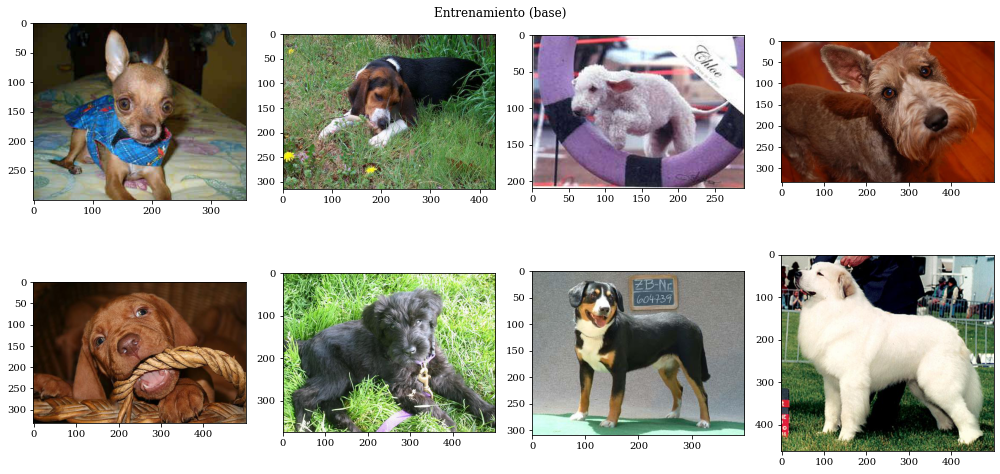

In [41]:
imgs = [i*int(len(base_rutas)/8) for i in range(8)]

plt.figure(figsize=(14,10))

for k,i in enumerate(imgs):
    plt.subplot(3, 4, k + 1)
    img = plt.imread(base_rutas[i])
    plt.imshow(img)
    
plt.suptitle('Entrenamiento (base)')
plt.tight_layout()
plt.show()

Y vemos algunas en el de prueba (consulta).

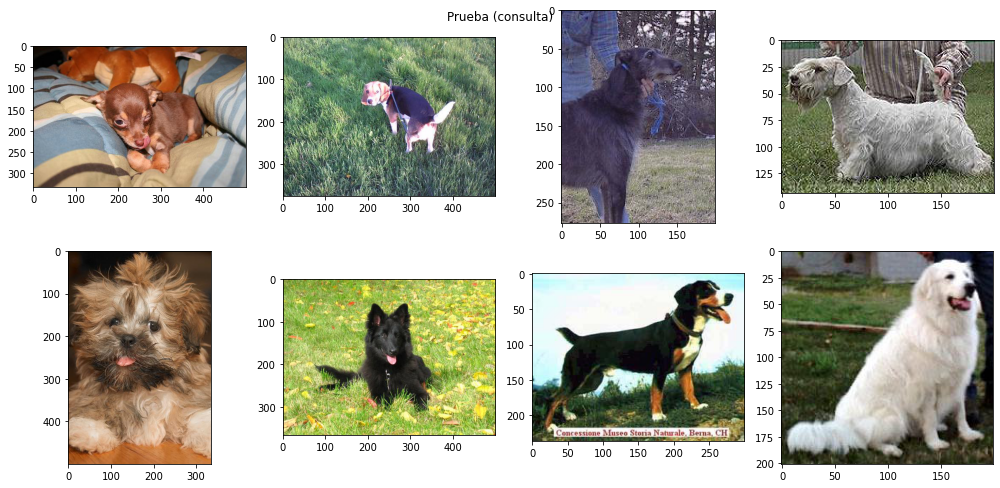

In [15]:
imgs = [i*int(len(consulta_rutas)/8) for i in range(8)]

plt.figure(figsize=(14,10))

for k,i in enumerate(imgs):
    plt.subplot(3, 4, k + 1)
    img = plt.imread(consulta_rutas[i])
    plt.imshow(img)

plt.suptitle('Prueba (consulta)')
plt.tight_layout()
plt.show()

## Bolsas de características

El formato de las bolsas es el siguiente:
- size_of_list_1 item1_1:freq1_1 item2_1:freq2_1 ...
- size_of_list_2 item1_2:freq1_2 item2_2:freq2_2 ...
- ...                        ...
- size_of_list_N item1_N:freq1_N item2_N:freq2_N ...

Por ejemplo, supongamos que tenemos

4 161286:1 151047:1 18449:1 226345:1,

eso se traduce en un vector de la siguiente manera

$$ [0, 0, \ldots, \underbrace{1}_{\text{posición 18449}}, \ldots, \underbrace{1}_{\text{posición 151047}}, \ldots, \underbrace{1}_{\text{posición 161286}}, \ldots, \underbrace{1}_{\text{posición 226345}}, \ldots] $$

**¿Es eso correcto?** Si es correcto entonces podemos construir una matriz de la siguiente manera (todas las frecuencias son 1 en las bolsas)

$$ \left( \begin{matrix}
	0 & 0 & 1 & \ldots & 1 & 1 & 1 & \ldots & 1 & 1 & 0 \\
	1 & 0 & 0 & \ldots & 1 & 0 & 0 & \ldots & 0 & 0 & 1 \\
	& \vdots &  &  &  & \vdots &  &  &  & \vdots &  \\
	1 & 1 & 0 & \ldots & 0 & 0 & 1 & \ldots & 1 & 1 & 0
\end{matrix} \right) .$$

El item máximo es $249499$, es decir, cada imagen tiene un vector de características de longitud $250000$ **¿es eso correcto?** De modo que para el caso de la bolsa de carácterísticas de las imágenes de entrenamiento (base) la matriz anterior será de $12000 \times 250000$ y para la de consulta será de $8580 \times 250000$.

**Observación: las matrices son muy dispersas, por el momento estoy usando matrices de numpy pero sería conveniente usar las sparse matrices de scipy.**

In [0]:
def leer_bolsa(ruta):
    
    """
    Lee las bolsas de características en los archivos 'dogs_ent.corpus' y 
    'dogs_val.corpus'. 
    """
    
    bolsas = []
    frecuencias = []
    
    with open(ruta, 'r') as f:
        
        for xs in f.readlines():
            
            # Separamos por espacios en blanco
            xs = xs.split()
            bolsa = []
            freqs = []
            
            for x in xs[1:]:
                # Ahora separamos por ':' que delimita item:freq
                item, freq = x.split(':')
                bolsa.append(int(item))
                freqs.append(int(freq))
                
            bolsas.append(bolsa)
            frecuencias.append(freqs)
            
    return bolsas, frecuencias

In [0]:
bolsas_base, frecuencias_base = leer_bolsa('Datos-masivos/LSH/dogs_ent.corpus')
bolsas_consulta, frecuencias_consulta = leer_bolsa('Datos-masivos/LSH/dogs_val.corpus')

**Las frecuencias siempre son 1 en las bolsas de características.**

In [0]:
def matrix_data(bolsas, shape):
    
    """
    Hace una matriz que contiene las bolsas de características de 'bolsas'.
    """
    
    M = np.zeros(shape, dtype = 'int8')
    
    for i, bolsa in enumerate(bolsas):
        for x in bolsa:
            M[i,x] = 1
            
    return M    

In [0]:
# matrix_train = matrix_data(bolsas_train, shape = (12000,250000))
# matrix_test = matrix_data(bolsas_test, shape = (8580,250000))

base = matrix_data(bolsas_base, shape = (12000,250000))
consultas = matrix_data(bolsas_consulta, shape = (8580,250000))

## LSH

Usamos la clase que está en la notebook [3e_lsh.ipynb](https://github.com/blancavazquez/CursoDatosMasivos/blob/master/notebooks/3e_lsh.ipynb).

In [0]:
class TablaLpLSH:
  def __init__(self, n_cubetas, t_tupla, dim, width, norma = 'l2'):
    self.n_cubetas = n_cubetas
    self.tabla = [[] for i in range(n_cubetas)]
    self.t_tupla = t_tupla
    self.dim = dim
    self.w = width

    if norma == 'l2':
      self.Amat = np.random.standard_normal((t_tupla, dim))
    elif norma == 'l1':
      self.Amat = np.random.standard_cauchy((t_tupla, dim))

    self.bvec = np.random.uniform(low=0, high=self.w, size=t_tupla)
    self.a = np.random.randint(0, np.iinfo(np.int32).max, size=self.t_tupla)
    self.b = np.random.randint(0, np.iinfo(np.int32).max, size=self.t_tupla)
    self.primo = 4294967291

  def __repr__(self):
    contenido = ['%d::%s' % (i, self.tabla[i]) for i in range(self.n_cubetas)]
    return "<TablaHash :%s >" % ('\n'.join(contenido))

  def __str__(self):
    contenido = ['%d::%s' % (i, self.tabla[i]) for i in range(self.n_cubetas) if self.tabla[i]]
    return '\n'.join(contenido)

  def sl(self, x, i):
    return (self.h(x) + i) % self.n_cubetas

  def h(self, x):
    return x % self.primo

  def lphash(self, x):
    prod = np.floor((self.Amat @ x.T + self.bvec) / self.w).astype(int)
    return np.sum(self.a * prod, dtype=np.ulonglong), np.sum(self.b * prod, dtype=np.ulonglong)
     
  def insertar(self, x, ident):
    lph, v2 = self.lphash(x)

    llena = True
    for i in range(self.n_cubetas):
      cubeta = int(self.sl(v2, i))
      if not self.tabla[cubeta]:
        self.tabla[cubeta].append(lph)
        self.tabla[cubeta].append([ident])
        llena = False
        break
      elif self.tabla[cubeta][0] == lph:
        self.tabla[cubeta][1].append(ident)
        llena = False
        break

    if llena:
      print('¡Error, tabla llena!')

  def buscar(self, x):
    mh, v2 = self.lphash(x)

    for i in range(self.n_cubetas):
      cubeta = int(self.sl(v2, i))
      if not self.tabla[cubeta]:
        return []
      elif self.tabla[cubeta][0] == mh:
        return self.tabla[cubeta][1]
        
    return []

In [0]:
def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x - y)**2))

def distancia_coseno(x, y):
    return np.arccos(np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)))

def fuerza_bruta(ds, qs, fd):
  medidas = np.zeros(ds.shape[0])
  for i,x in enumerate(ds):
    medidas[i] = fd(qs, x)

  return np.sort(medidas), np.argsort(medidas)

In [0]:
def display_similar(indices_consultas, vmc_lsh):
    """
    Despliega las 5 imágenes más similares de las imágenes de consulta correspondientes
    a indices_consultas
    """
    
    for i,j in enumerate(indices_consultas):
        plt.figure(1, figsize = (5,5))
        img_consulta = plt.imread(consulta_rutas[j])
        plt.imshow(img_consulta)
        plt.axis('off')
        plt.tight_layout()
        
        plt.figure(2, figsize=(20,10))
        
        for k in range(5):
            img_similar = plt.imread(base_rutas[vmc_lsh[i][k]])
            plt.subplot(1, 5, k + 1)
            plt.imshow(img_similar)
            plt.axis('off')
            plt.tight_layout()   
            
        plt.show()

## Prueba con la distancia euclidiana

Instanciamos las tablas.

In [0]:
n_tablas = 100
dim = base.shape[1]
tablas = [TablaLpLSH(2**15, 2, dim, 100000.0) for _ in range(n_tablas)]

Insertamos los vectores en cada tabla (esto se tarda como media hora en Colab)

In [58]:
for i,x in enumerate(base):
    for t in range(n_tablas):
        tablas[t].insertar(x, i)
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


Realizamos la búsqueda de los vectores de consulta y recuperamos los vectores más similares del conjunto base.

In [0]:
# índices correspondientes a perros labradores 
indices_consultas = [4500, 4510]

In [0]:
vecs = []
for i,q in enumerate(consultas[indices_consultas]):
  dc = []
  for t in range(n_tablas):
      dc.extend(tablas[t].buscar(q))
  vecs.append(set(dc))

In [61]:
dists = []
orden = []

for i,q in enumerate(consultas[indices_consultas]):
    print(i)
    ld = list(vecs[i])
    if ld:
        m,o = fuerza_bruta(base[ld], q, distancia_euclidiana)
        dists.append(m)
        orden.append([ld[e] for e in o])
    else:
        dists.append([])
        orden.append([])

0
1


In [62]:
# Agarramos los 5 más parecidos
vmc_lsh = [o[0:5] if o else -1 for o in orden]
vmc_lsh

[[11876, 23, 11929, 2495, 1673], [11876, 23, 8873, 1673, 2495]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


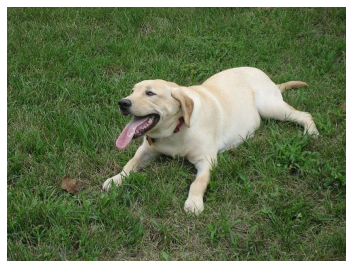

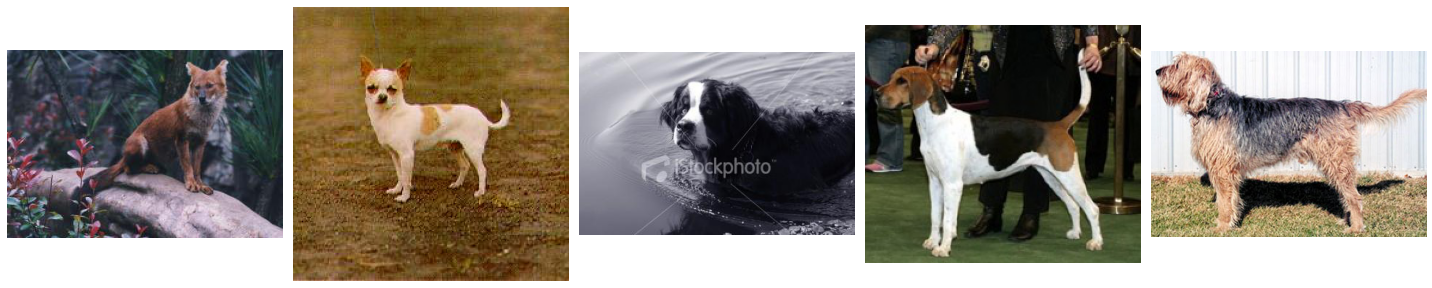

In [63]:
display_similar(indices_consultas, vmc_lsh) # Colab no imprime la otra consulta, lo arreglaré después

## Prueba con la distancia coseno

In [0]:
vecs = []
for i,q in enumerate(consultas[indices_consultas]):
  dc = []
  for t in range(n_tablas):
      dc.extend(tablas[t].buscar(q))
  vecs.append(set(dc))

In [65]:
dists = []
orden = []

for i,q in enumerate(consultas[indices_consultas]):
    print(i)
    ld = list(vecs[i])
    if ld:
        m,o = fuerza_bruta(base[ld], q, distancia_coseno)
        dists.append(m)
        orden.append([ld[e] for e in o])
    else:
        dists.append([])
        orden.append([])

0
1


In [66]:
# Agarramos los 5 más parecidos
vmc_lsh = [o[0:5] if o else -1 for o in orden]
vmc_lsh

[[8585, 217, 11682, 2025, 4363], [2752, 3080, 5733, 7337, 2968]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


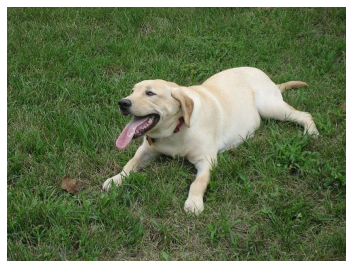

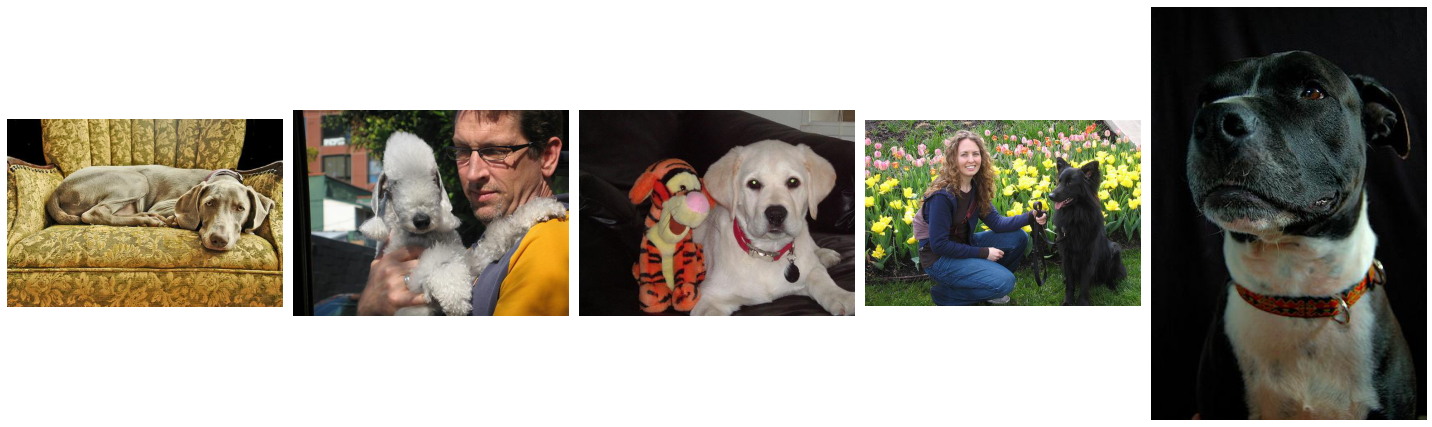

In [67]:
display_similar(indices_consultas, vmc_lsh)# Colab no imprime la otra consulta, lo arreglaré después